This colab accompanies the HierText dataset \[[Github](https://github.com/google-research-datasets/hiertext#evaluation)\].

This colab visualizes the annotations by coloring words/lines/paragraphs. Text entities that are annotated as illigeble have white color.

In [33]:
# --- imports ---
import os, json, random
import numpy as np
import cv2
from matplotlib import pyplot as plt

# --- which subset to visualize ---
SPLIT = "train"   # "train" | "validation" | "test"


In [28]:
def find_project_root(start_dir):
    cur = os.path.abspath(start_dir)
    for _ in range(6):  # walk up to 6 levels just in case
        data_dir = os.path.join(cur, "Data")
        if os.path.isdir(os.path.join(data_dir, "gt")):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            break
        cur = parent
    return os.path.abspath(start_dir)

NB_DIR = os.getcwd()
PROJECT_ROOT = find_project_root(NB_DIR)

DATA_DIR = os.path.join(PROJECT_ROOT, "Data")
GT_DIR   = os.path.join(DATA_DIR, "gt")
IMG_DIR  = os.path.join(DATA_DIR, SPLIT)
ANN_PATH = os.path.join(GT_DIR, f"{SPLIT}.jsonl")   # file is named .jsonl but may be JSON or JSONL

print("Project root:", PROJECT_ROOT)
print("Images dir  :", IMG_DIR)
print("Ann file    :", ANN_PATH)
assert os.path.isdir(IMG_DIR), "Images directory missing"
assert os.path.isfile(ANN_PATH), "Annotation file missing"


Project root: c:\Users\aryan\GitHub\DL_Project
Images dir  : c:\Users\aryan\GitHub\DL_Project\Data\train
Ann file    : c:\Users\aryan\GitHub\DL_Project\Data\gt\train.jsonl


In [29]:
def load_hiertext_annotations(path):
    # Peek at the beginning of the file to detect format
    with open(path, "r", encoding="utf-8-sig", errors="replace") as f:
        head = f.read(4096)
    first_nonempty = next((ln.strip() for ln in head.splitlines() if ln.strip()), "")

    # Case A: JSON Lines (each line is a JSON object with "image_id")
    if first_nonempty.startswith("{") and '"image_id"' in first_nonempty and '"annotations"' not in first_nonempty:
        anns = []
        with open(path, "r", encoding="utf-8-sig", errors="replace") as f:
            for line in f:
                s = line.strip()
                if not s:
                    continue
                anns.append(json.loads(s))
        return anns

    # Case B: Single JSON object or array
    with open(path, "r", encoding="utf-8-sig", errors="replace") as f:
        data = json.load(f)

    # If wrapped as {"info":..., "annotations":[...]}
    if isinstance(data, dict) and "annotations" in data:
        return data["annotations"]

    # If it is already a list
    if isinstance(data, list):
        return data

    raise ValueError("Unrecognized annotation format at: " + path)

anns = load_hiertext_annotations(ANN_PATH)
print(f"Loaded {len(anns)} annotations for split '{SPLIT}'")
print("Example keys:", list(anns[0].keys()))


Loaded 8281 annotations for split 'train'
Example keys: ['image_id', 'paragraphs', 'image_width', 'image_height']


In [46]:
def show_record(rec, split=SPLIT, level="word", alpha=0.35, show_text=True):
    """
    level: "word" | "line" | "paragraph" | "all"
    show_text: draw word text when level includes words
    """
    image_id = rec["image_id"]
    img_path = os.path.join(DATA_DIR, split, f"{image_id}.jpg")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    overlay = img.copy()

    # colors
    C_PARA = (255,179,0)   # orange
    C_LINE = (0,200,255)   # cyan
    C_WORD = (255, 51,51)  # red

    def get_poly(o):  # supports both schema variants
        return o.get("polygon") or o.get("vertices")

    draw_words = level in ("word", "all")
    draw_lines = level in ("line", "all")
    draw_paras = level in ("paragraph", "all")

    for p in rec.get("paragraphs", []):
        if draw_paras:
            poly = get_poly(p)
            if poly is not None:
                cv2.polylines(overlay, [np.array(poly, np.int32)], True, C_PARA, 3)

        for l in p.get("lines", []):
            if draw_lines:
                poly = get_poly(l)
                if poly is not None:
                    cv2.polylines(overlay, [np.array(poly, np.int32)], True, C_LINE, 2)

            if draw_words:
                for w in l.get("words", []):
                    poly = get_poly(w)
                    if poly is None: 
                        continue
                    pts = np.array(poly, np.int32)
                    cv2.polylines(overlay, [pts], True, C_WORD, 2)
                    if show_text:
                        x, y = int(pts[0][0]), int(pts[0][1])
                        cv2.putText(overlay, w.get("text",""), (x, y),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)

    out = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    plt.figure(figsize=(12, 8))
    plt.title(f"{split} / {image_id} / level={level}")
    plt.imshow(out); plt.axis("off"); plt.show()


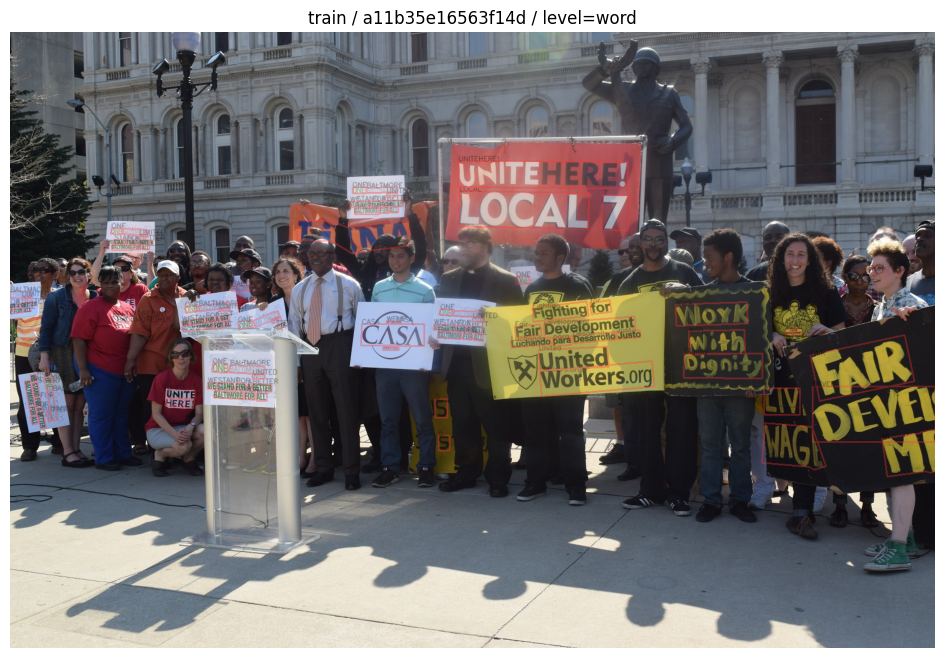

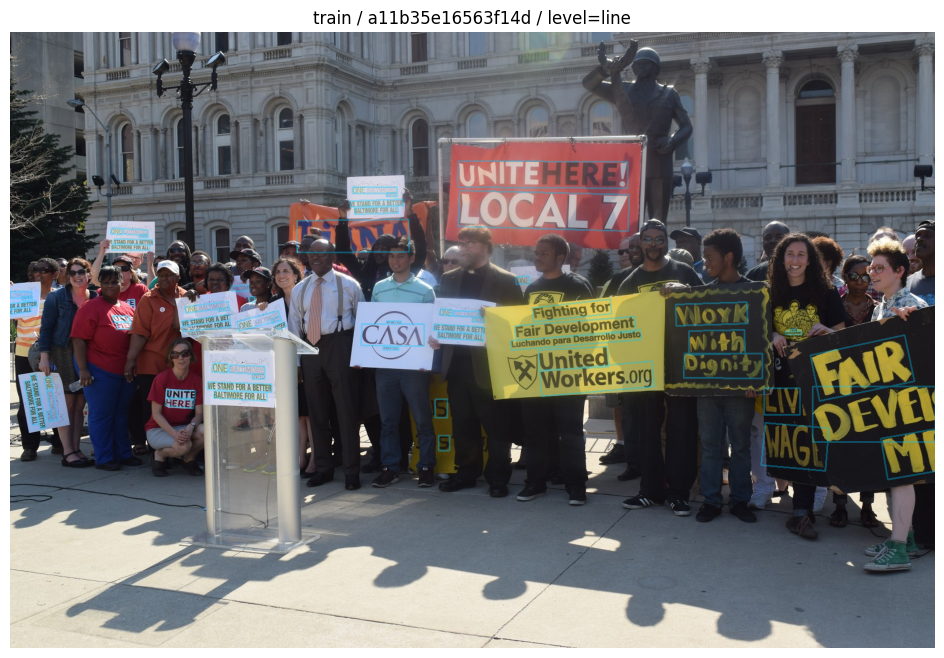

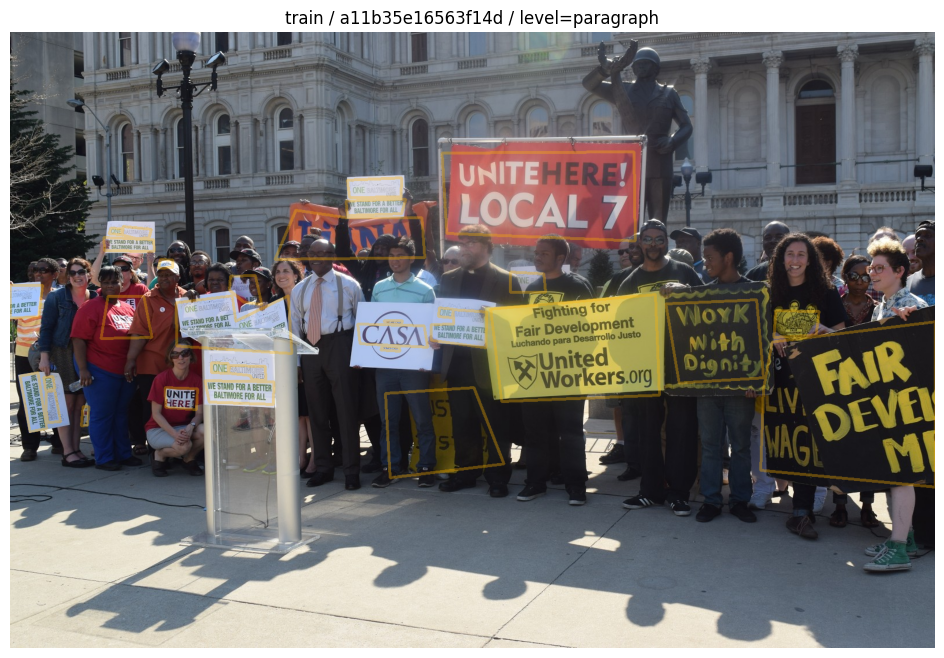

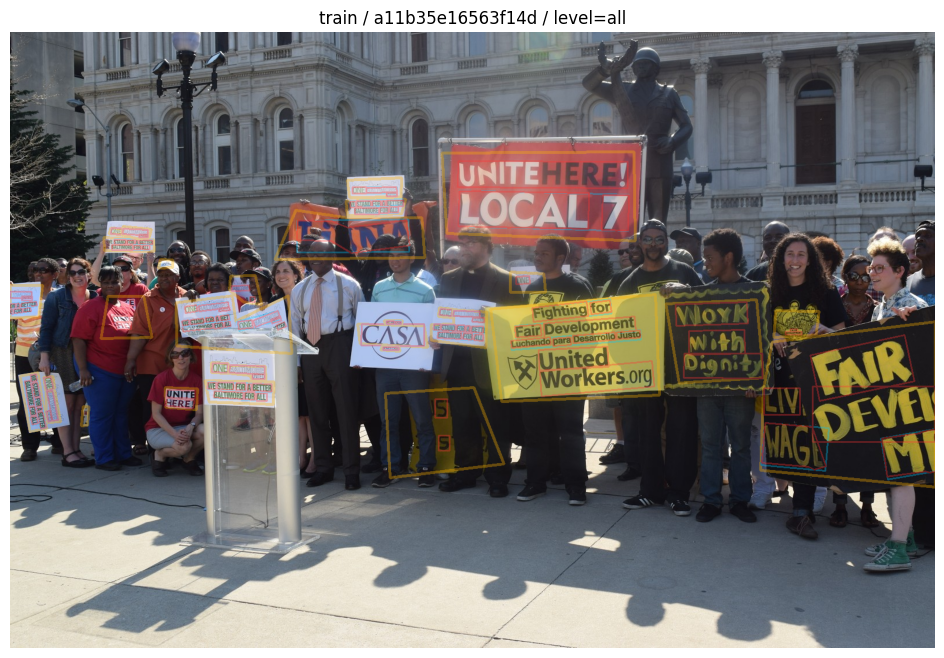

In [47]:
rec = random.choice(anns)

# show only words (with text labels)
show_record(rec, SPLIT, level="word", show_text=True)

# show only lines
show_record(rec, SPLIT, level="line", show_text=False)

# show only paragraphs
show_record(rec, SPLIT, level="paragraph")

# show all three levels together (para + line + word)
show_record(rec, SPLIT, level="all", show_text=False)


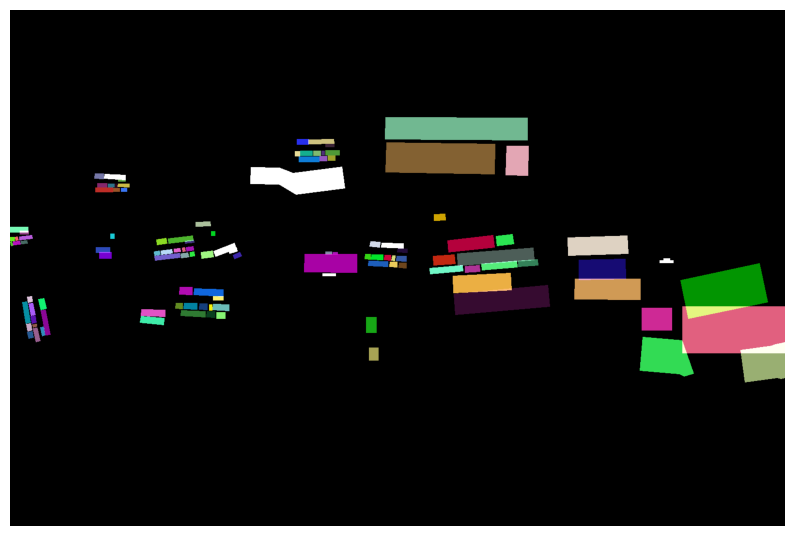

In [48]:
m, wts = masks_from_record(rec, level="word")        # or "line" / "paragraph"
visualize_masks(m, wts, figsize=10)
